In [1]:
#Este analisis verifica si la cercanía a hospitales y centros de salud privados afecta el precio.

import pandas as pd
import numpy as np
import shapely
import matplotlib.pyplot as plt
%matplotlib inline
%config IPCompleter.greedy=True

In [2]:
#Datos de Properati
#data = pd.read_csv('/home/martin/Documents/jupyter/datasets/properati-AR-2017-08-01-properties-sell.csv')

#Datos procesados
data = pd.read_csv('datos_procesados.csv',low_memory = False)

#Tomo los datos que me interesan: estado, barrio, superficie, precio por m2, latitud y longitud)
data2 = data[['state_name', 'place_name','price_usd_per_m2','lat', 'lon']]

#Elimino NAs
data2.dropna(inplace=True)

#Separo los datos en Capital Federal
dataCF = data2[data2['state_name']== 'Capital Federal']

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


In [3]:
#Datos de establecimientos de salud

#Hospitales. Datos extraídos de: https://data.buenosaires.gob.ar/dataset/areas-hospitalarias
hospital = pd.read_csv('areas-hospitalarias.csv', sep = ";",low_memory = False) 

#Centros de salud privados. Datos extraídos de: https://data.buenosaires.gob.ar/dataset/centros-de-salud-privados
privado = pd.read_csv('centros-de-salud-privados.csv', sep = ";",low_memory = False) 

In [4]:
privado.sample(5)


,NOMBRE,DIRECCION,CALLE,ALTURA,PISO,TELEFONOS,OBSERV,BARRIO,COMUNA,CODIGO_POSTAL,CODIGO_POSTAL_ARGENTINO,LAT,LNG
19,HOSPITAL DE CLINICAS JOSE DE SAN MARTIN,CORDOBA AV. 2351,CORDOBA AV.,2351,NaN,5950-8000,NOVIEMBRE 2012:OK,RECOLETA,COMUNA 2,1120,C1120AAF,"-34,59931303","-58,40059894"
44,CENTRO MEDICO DR. CALABRESE,SARMIENTO AV. 4470,SARMIENTO AV.,4470,NaN,NaN,NOVIEMBRE 2012:SIN PAGINA EN INTERNET PARA CHE...,PALERMO,COMUNA 14,1425,C1425FHS,"-34,60424412","-58,42838953"
36,SANATORIO DE LOS ARCOS,"JUSTO, JUAN B. AV. 909","JUSTO, JUAN B. AV.",909,NaN,4778-4500,NOVIEMBRE 2012:OK,PALERMO,COMUNA 14,1425,C1425FSD,"-34,58096794","-58,42931153"
18,HOSPITAL DE ASMA Y ALERGIA,POTOSI 3880,POTOSI,3880,NaN,NaN,NOVIEMBRE 2012: SIN PAGINA EN INTERNET PARA CH...,ALMAGRO,COMUNA 5,1199,C1199ACD,"-34,60749541","-58,42109772"
41,SANATORIO OTAMENDI Y MIROLI,AZCUENAGA 870,AZCUENAGA,870,NaN,4963-8888 / 4961-0305,NOVIEMBRE 2012:OK,RECOLETA,COMUNA 2,1115,C1115AAB,"-34,59842828","-58,40107461"


In [5]:
#Tomo los datos que me interesan
privado2 = privado[['NOMBRE','LAT','LNG']]
#Cambio las comas en latitud y longitud por puntos para poder usarlos como float
privado2['lat'] = privado2['LAT'].str.replace(',','.').astype(float)
privado2['lon'] = privado2['LNG'].str.replace(',','.').astype(float)

privado = privado2[['NOMBRE','lat','lon']]
privado.sample(5)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


,NOMBRE,lat,lon
23,HOSPITAL ISRAELITA- ISRAMED,-34.619312,-58.473685
1,CAMI - MEDICINA DEL TRABAJO,-34.612884,-58.420476
11,CLINICA SAN CAMILO,-34.606251,-58.442518
22,HOSPITAL FRANCES (PAMI),-34.621507,-58.407734
12,CLINICA Y MATERNIDAD SANTA ISABEL,-34.631592,-58.455904


In [6]:
hospital2 = hospital[['NOMBRE', 'WKT']]
hospital2.head(12)
#Esto queda para hacer después (no sé geopandas)

,NOMBRE,WKT
0,HTAL. DR. J.M. RAMOS MEJIA,POLYGON ((-58.411918809529602 -34.598003076028...
1,HTAL. DR. A. ZUBIZARRETA,POLYGON ((-58.493245503955578 -34.581023364390...
2,HTAL. DR. C.G. DURAND,POLYGON ((-58.426948408976038 -34.596211287114...
3,HTAL. DR. T. ALVAREZ,POLYGON ((-58.460528905637787 -34.596353609283...
4,HTAL. VELEZ SARSFIELD,POLYGON ((-58.488444607967679 -34.609456721242...
5,HTAL. DR. F. SANTOJANI,POLYGON ((-58.474548852531036 -34.674558997865...
6,"HTAL. DR, E. TORNU",POLYGON ((-58.467044778470367 -34.579089660706...
7,HTAL. J.A.FERNANDEZ,POLYGON ((-58.427262948617766 -34.549791222454...
8,HTAL. DR. PIROVANO,POLYGON ((-58.456633201780775 -34.527558272632...
9,HTAL. DR. P. PIÑERO,POLYGON ((-58.445213023784945 -34.622058210435...


In [7]:
#Direcciones extraídas de Google Maps
#HTAL. DR. J.M. RAMOS MEJIA: (-34.617369, -58.410183)
#HTAL. DR. A. ZUBIZARRETA:   (-34.599915, -58.510748)
#HTAL. DR. C.G. DURAND:      (-34.609531, -58.438305)
#HTAL. DR. T. ALVAREZ:       (-34.623738, -58.469683)
#HTAL. VELEZ SARSFIELD:      (-34.625355, -58.507623)
#HTAL. DR. F. SANTOJANI:     (-34.648925, -58.515292)
#HTAL. DR, E. TORNU:         (-34.586471, -58.471636)
#HTAL. J.A.FERNANDEZ:        (-34.581443, -58.406978)
#HTAL. DR. PIROVANO:         (-34.564832, -58.470934)
#HTAL. DR. P. PIÑERO:        (-34.644780, -58.454385)
#HTAL. J.M. PENNA:           (-34.643191, -58.410067)
#HTAL. DR. C. ARGERICH:      (-34.628252, -58.365549)

hospital2['lat'] = 0.

hospital2.at[0, 'lat'] = -34.617369
hospital2.at[1, 'lat'] = -34.599915
hospital2.at[2, 'lat'] = -34.609531
hospital2.at[3, 'lat'] = -34.623738
hospital2.at[4, 'lat'] = -34.625355
hospital2.at[5, 'lat'] = -34.648925
hospital2.at[6, 'lat'] = -34.586471
hospital2.at[7, 'lat'] = -34.581443
hospital2.at[8, 'lat'] = -34.564832
hospital2.at[9, 'lat'] = -34.644780
hospital2.at[10, 'lat'] = -34.643191
hospital2.at[11, 'lat'] = -34.628252

hospital2['lon'] = 0.

hospital2.at[0, 'lon'] = -58.410183
hospital2.at[1, 'lon'] = -58.510748
hospital2.at[2, 'lon'] = -58.438305
hospital2.at[3, 'lon'] = -58.469683
hospital2.at[4, 'lon'] = -58.507623
hospital2.at[5, 'lon'] = -58.515292
hospital2.at[6, 'lon'] = -58.471636
hospital2.at[7, 'lon'] = -58.406978
hospital2.at[8, 'lon'] = -58.470934
hospital2.at[9, 'lon'] = -58.454385
hospital2.at[10, 'lon'] = -58.410067
hospital2.at[11, 'lon'] = -58.365549

hospublico = hospital2[['NOMBRE', 'lat', 'lon']]
hospublico.head(12)

/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/home/martin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,NOMBRE,lat,lon
0,HTAL. DR. J.M. RAMOS MEJIA,-34.617369,-58.410183
1,HTAL. DR. A. ZUBIZARRETA,-34.599915,-58.510748
2,HTAL. DR. C.G. DURAND,-34.609531,-58.438305
3,HTAL. DR. T. ALVAREZ,-34.623738,-58.469683
4,HTAL. VELEZ SARSFIELD,-34.625355,-58.507623
5,HTAL. DR. F. SANTOJANI,-34.648925,-58.515292
6,"HTAL. DR, E. TORNU",-34.586471,-58.471636
7,HTAL. J.A.FERNANDEZ,-34.581443,-58.406978
8,HTAL. DR. PIROVANO,-34.564832,-58.470934
9,HTAL. DR. P. PIÑERO,-34.644780,-58.454385


In [8]:
#Busco, para cada propiedad, el centro de salud más cercano

#Agrego una columna donde irá la distancia minima al centro de salud más cercano
precio_segun_distancia = dataCF.copy()
#Agrego 2 columnas donde va a ir la informacion
precio_segun_distancia.head(10)
privado.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 3 columns):
NOMBRE    65 non-null object
lat       65 non-null float64
lon       65 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.6+ KB


In [9]:
#Defino una funcion que calcula la distancia entre dos puntos
import math
def dist(lat1,lon1,lat2,lon2):
    dLat = math.radians(lat2-lat1)
    dLon = math.radians(lon2-lon1)

    lat1 = math.radians(lat1)
    lat2 = math.radians(lat2)

    a = math.sin(dLat/2) * math.sin(dLat/2) + math.sin(dLon/2) * math.sin(dLon/2) * math.cos(lat1) * math.cos(lat2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
    return c * 6371 * 1000
    #return np.abs((lat1 - lat2) + (lon1 - lon2))

In [10]:
#Encuentra el hospital o centro de salud privado más cercano a las coordenadas dadas
def encontrar_mas_cercano(lat, lon, fuente):
    distancias = fuente.apply(lambda row: dist(lat, lon, row['lat'], row['lon']), axis=1)
    return fuente.loc[distancias.idxmin(), 'NOMBRE']

#Calcula la distancia mínima a un hospital o centro de salud
def dist2(lat,lon,fuente):
    distancias = fuente.apply(lambda row: dist(lat, lon, row['lat'], row['lon']), axis=1)
    return distancias.min()

In [11]:
#Agrego columnas al dataframe con el hospital privado y centro privado más cercanos
#y las distancias mínimas a los mismos
precio_segun_distancia['privado_mas_cercano'] = precio_segun_distancia.apply(lambda row: encontrar_mas_cercano(row['lat'], row['lon'], privado), axis=1)
precio_segun_distancia['distancia_minima_privado (m)'] = precio_segun_distancia.apply(lambda row: dist2(row['lat'],row['lon'],privado), axis=1)

precio_segun_distancia['publico_mas_cercano'] = precio_segun_distancia.apply(lambda row: encontrar_mas_cercano(row['lat'], row['lon'], hospublico), axis=1)
precio_segun_distancia['distancia_minima_publico (m)'] = precio_segun_distancia.apply(lambda row: dist2(row['lat'],row['lon'], hospublico), axis=1)


precio_segun_distancia.sample(10)

,state_name,place_name,price_usd_per_m2,lat,lon,privado_mas_cercano,distancia_minima_privado (m),publico_mas_cercano,distancia_minima_publico (m)
453547,Capital Federal,Villa Crespo,2604.166667,-34.593808,-58.444101,CLINICA SAN CAMILO,1391.153915,HTAL. DR. C.G. DURAND,1826.999430
444597,Capital Federal,Villa Devoto,1790.000000,-34.591433,-58.512690,HOSPITAL DE ONCOLOGIA ANGEL H. ROFFO,1765.902502,HTAL. DR. A. ZUBIZARRETA,959.820043
463012,Capital Federal,Caballito,2264.150943,-34.627268,-58.440435,INSTITUTO ANTARTIDA,1086.574587,HTAL. DR. C.G. DURAND,1981.881581
453470,Capital Federal,Caballito,1759.259259,-34.625653,-58.453434,CLINICA Y MATERNIDAD SANTA ISABEL,698.024440,HTAL. DR. T. ALVAREZ,1501.935679
455717,Capital Federal,Almagro,2705.212647,-34.601537,-58.424469,CENTRO MEDICO DR. CALABRESE,468.425412,HTAL. DR. C.G. DURAND,1547.201789
453669,Capital Federal,San Cristobal,1431.818182,-34.620987,-58.382961,CLINICA BASILEA,673.977379,HTAL. DR. C. ARGERICH,1786.348474
421928,Capital Federal,Villa General Mitre,1714.285714,-34.611502,-58.464037,POLICLINICA BANCARIA 9 DE JULIO,621.838544,HTAL. DR. T. ALVAREZ,1455.327928
471494,Capital Federal,Palermo,2739.130435,-34.568244,-58.430829,HOSPITAL MILITAR CENTRAL,531.842470,HTAL. J.A.FERNANDEZ,2631.083490
415081,Capital Federal,Villa Crespo,3580.530973,-34.597770,-58.426440,SANATORIO GUEMES,387.986591,HTAL. DR. C.G. DURAND,1699.858254
399759,Capital Federal,Belgrano,1337.529504,-34.571744,-58.461653,CLINICA ADVENTISTA BELGRANO,687.235065,HTAL. DR. PIROVANO,1145.801889


In [12]:
print(len(precio_segun_distancia))
precio_segun_distancia.dropna(inplace=True)
print(len(precio_segun_distancia))

36942
36942


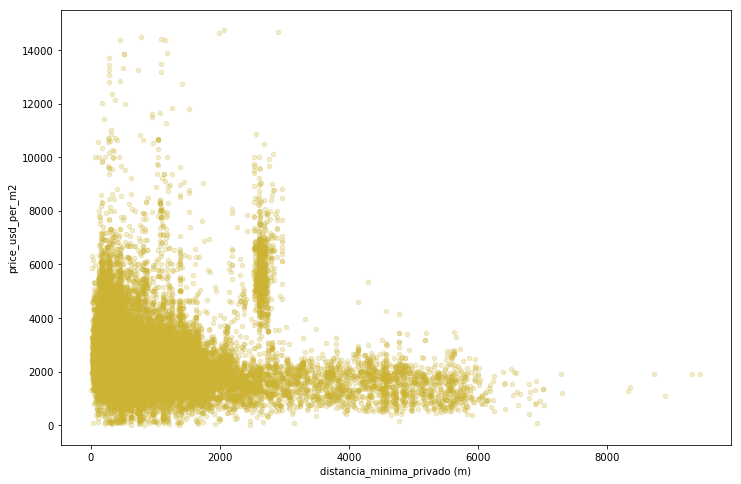

In [13]:
#Evaluo la relacion entre precio y distancia a centros de salud privada

precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['price_usd_per_m2']< 15000]
precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['distancia_minima_privado (m)']< 10000]
precio_segun_distancia.plot.scatter('distancia_minima_privado (m)', 'price_usd_per_m2',alpha=0.25, figsize=(12,8),color=(0.8,0.7,0.2))

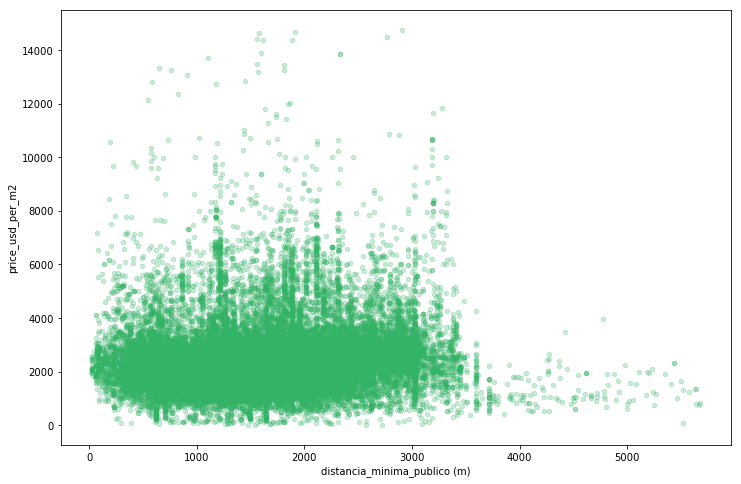

In [14]:
#Evaluo la relacion entre precio y distancia a hospitales publicos

precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['price_usd_per_m2']< 15000]
precio_segun_distancia = precio_segun_distancia[precio_segun_distancia['distancia_minima_publico (m)']< 6000]
precio_segun_distancia.plot.scatter('distancia_minima_publico (m)', 'price_usd_per_m2',alpha=0.25, figsize=(12,8),color=(0.2,0.7,0.4))

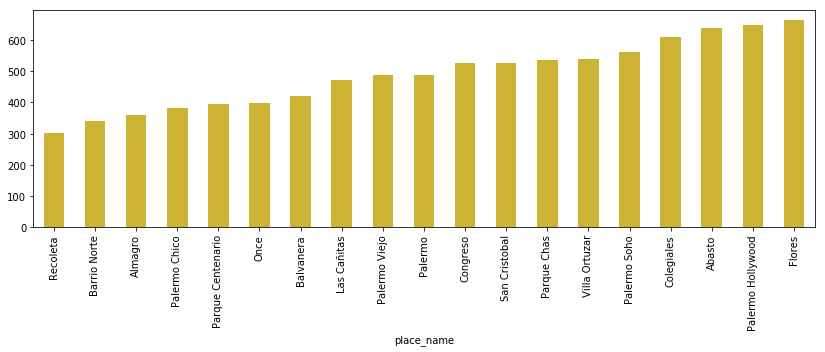

In [15]:
#Barrios con mas acceso a centros de salud privada
precio_segun_distancia.groupby(['place_name'], sort=False)['distancia_minima_privado (m)'].mean().sort_values(ascending=True)[0:19].plot(kind='bar',figsize=(14,4), color=(0.8,0.7,0.2));

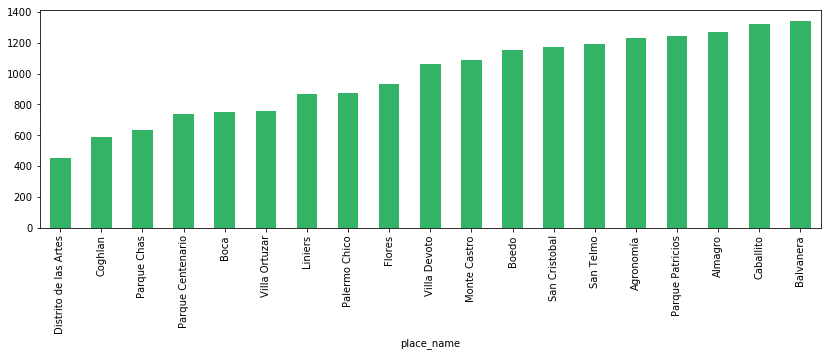

In [16]:
#Barrios con mas acceso a hospitales públicos
precio_segun_distancia.groupby(['place_name'], sort=False)['distancia_minima_publico (m)'].mean().sort_values(ascending=True)[0:19].plot(kind='bar',figsize=(14,4), color=(0.2,0.7,0.4));

In [ ]:
#Comparo estos barrios con los que tienen mayor precio por metro cuadrado, y hay mayor concordancia entre los que están más próximos a centros de salud privada que hospitales públicos.

#Concluimos que la proximidad a centros de salud privada aumentan el precio, mientras que la proximidad a hospitales públicos no lo afecta de manera considerable.